In [1]:
import yfinance as yf

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScalar
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import numpy as np
import xgboost as xgb

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import folium
import math
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import HTML
from dash import Dash, html, dcc, callback, Output, Input

In [4]:
from sklearn.preprocessing import MinMaxScaler

https://www.kaggle.com/code/owczar/gam-model-for-time-series-forecasting

# 1.Data Processing
###  - Data: S&P500 index (sp500)

In [7]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period ="max")

In [8]:
## Create a new feature called "yesterday" and drop all data with N/A 
sp500['yesterday'] = sp500.Close.shift(1)
sp500 = sp500.dropna()

In [9]:
## Understanding the features
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24340 entries, 1928-01-03 00:00:00-05:00 to 2024-11-21 00:00:00-05:00
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          24340 non-null  float64
 1   High          24340 non-null  float64
 2   Low           24340 non-null  float64
 3   Close         24340 non-null  float64
 4   Volume        24340 non-null  int64  
 5   Dividends     24340 non-null  float64
 6   Stock Splits  24340 non-null  float64
 7   yesterday     24340 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 1.7 MB


In [10]:
## convert the Sp500 indexes to a data_time object for easier manipulation based on date and time
sp500.index = pd.to_datetime(sp500.index)

# 2. Generating the train and test data 

###  - Methods for generating test/train data

In [13]:
### Used for generating empty df with indexes as dates
### If given 365 days, creates future dates, that only include weekdays.
### It's easy to imagine that it creates 365 days, then discards all the weekends.
### If today is Jan 1, 2024, it will create up to Jan 1, 2025
# input: days (int)
# output: (Pandas DataFrame object) 
def generateFutureDates(days):
    today = pd.to_datetime('today').normalize()
    
    period = days
    pred_range = pd.date_range(start = today, periods = period, freq="D")
    temp_df = pd.DataFrame(index=pred_range)
    temp_df2 = createSeasonalFeatures(temp_df)
    temp_df2 = temp_df2[temp_df2['dayofweek'] < 5]
    return temp_df2

In [14]:
## This method divides the test and train data based on the year given. 
#   input: (type pandas-dataframe, int, int, int, int) df, train_year_start, train_year_end, test_year_start, test_year_end
#   output: (type list list) test, train
def generateTrainTest(train_year_start, train_year_end, test_year_start, test_year_end=0, df=sp500):
    train_year_start = str('01-01-' + str(train_year_start))
    train_year_end = str('31-12-' + str(train_year_end))
    test_year_start = str('01-01-' + str(test_year_start))
    test_year_end = str('31-12-' + str(test_year_end))
    
    
    sp_train = df.iloc[(df.index < train_year_end)& (df.index > train_year_start)] 
    sp_test = None
    ## if no test-
    if(test_year_end == 0):
        sp_test = df.iloc[df.index >= test_year_start]
    sp_test = df.iloc[(df.index < test_year_end)& (df.index > test_year_start)]     
    
    ## Drop data that can cause data leakage
    sp_test.drop('yesterday', axis=1)
    
    return sp_train, sp_test
    

In [15]:


## Define features that will be inspected
# FEATURES_TRAIN = ['quarter', 'year', 'month', 'dayofweek', 'yesterday']
# FEATURES_TEST = ['quarter', 'year', 'month', 'dayofweek', 'abs_date_index']
# TARGET = 'Close'
FEATURES_TRAIN = ['quarter', 'year', 'month', 'dayofweek', 'yesterday']
FEATURES_TEST = ['quarter', 'year', 'month', 'dayofweek']
TARGET = 'Close'


## given a df, it adds seasonal features defined above
## new values are also generated based on the date information in the df
# Input: DF object
# Output: DF object

def createSeasonalFeatures(df):
    DF = df.copy()
    DF["quarter"] = df.index.quarter    
    DF["year"] = df.index.year
    DF["month"] = df.index.month
    DF["dayofweek"] = df.index.dayofweek
    # DF["abs_date_index"] = (df.index.dayofyear * (1/365) ) + df.index.year
    return DF

### - generating test data and visualization

#####   NOTE • Range of data for train data [1980-2020]   • Range of data for test data [2021-2024]

In [18]:
## BLOCK THAT Preprocesses 

## Acquire training and test data
train, test = generateTrainTest(1980, 2020, 2021,2024)
## Add on seasonal data (quarter, month, day, etc)
test = createSeasonalFeatures(test)
train = createSeasonalFeatures(train)

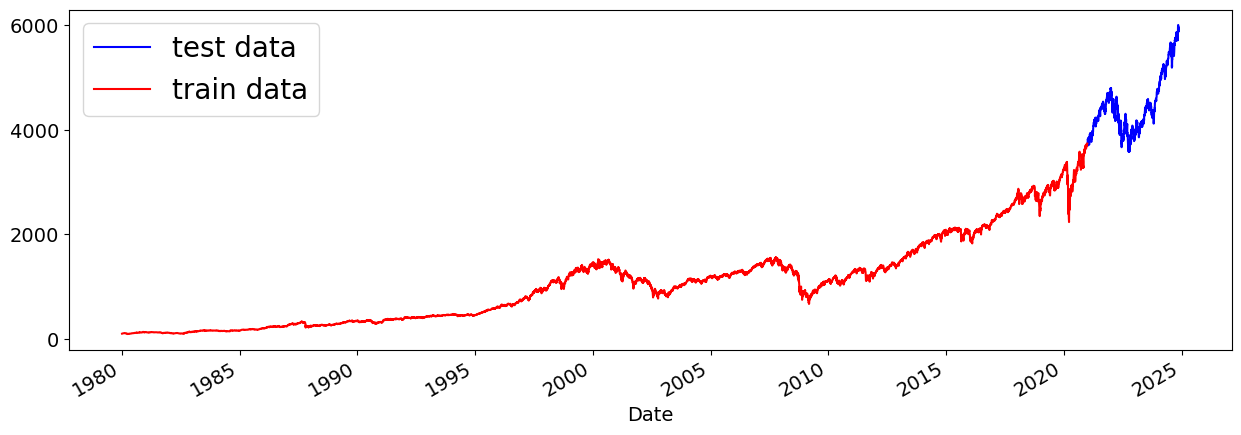

In [97]:
## Visualize Training Data(red) and Testing Data(blue)
fig, ax = plt.subplots(figsize = (15,5))
test.Close.plot(ax = ax, label="test data", color = "blue")
train.Close.plot(ax = ax, label="train data", color = "red")
plt.rcParams.update({'font.size': 20})
ax.legend()

####  - generating input X and output Y for both test and train data 

In [21]:
# Accepts TRAIN data and returns X and Y
def separateTrainXY(train_data, features, target):
    FEATURES = features
    TARGET = target
    x_train = train_data[FEATURES_TRAIN] 
    y_train = train_data[TARGET]
    return x_train, y_train

# Accepts TEST data and returns X and Y
def separateTestXY(test_data, features, target):    
    FEATURES_TEST = features
    TARGET = target
    x_test = test_data[FEATURES_TEST]
    y_test = test_data[TARGET]
    return x_test, y_test

In [22]:
x_train, y_train = separateTrainXY(train, FEATURES_TRAIN, TARGET)
x_test, y_test = separateTestXY(test, FEATURES_TEST, TARGET)

# 3. Training the Model

In [24]:
model1 = xgb.XGBRegressor(n_estimators=3000, learning_rate = 0.02, max_depth=10)
model1.fit(x_train, y_train, 
           verbose = True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [25]:
pd.DataFrame(data = model1.feature_importances_,
            index = FEATURES_TRAIN,
            columns = ["importance"])

,importance
quarter,0.000093
year,0.059484
month,0.000108
dayofweek,0.000073
yesterday,0.940241


In [26]:
def modelPredict(model_, train, test, x_test):
    x_test_ = x_test.copy()
    last_close_price = train.iloc[-1].Close

    ## DataFrame to store predictions
    predictions = []

    
    ## Predict day by day
    for i in range(len(x_test_)):
        current_features = x_test_.iloc[[i]].copy()
        
        current_features["yesterday"] = last_close_price


        ## Predict stock price for the current day
        predicted = model_.predict(current_features)
        
        ## temp add to add date exp
        # predicted *
        predictions.append(predicted)
        last_close_price = predicted
    

    pred_list = []
    for i, element in enumerate(predictions):
        pred_list.append(element[0])
    
    x_test_['prediction'] = pred_list
        
    return x_test_


# 4.Visualization Tools

In [28]:
def visualizePredictions(prediction, df):
    ax = df['Close'].plot( color = "black", label='actual')
    prediction['prediction'].plot(ax=ax, color = "purple", label='predicted')
    ax.legend()
    plt.show()

In [29]:
def visualizePredictionsArtificialInflation(prediction, df):
    incremented_predictions = prediction.copy()
    incremented_predictions['prediction'] = incremented_predictions['prediction'] + range(1, 2 * len(prediction) + 1, 2)
    ax = df['Close'].plot( color = "black", label='actual')
    incremented_predictions['prediction'].plot(ax=ax, label='prediction', color = "purple")
    ax.legend()
    plt.show()

In [146]:
def PLTvisualize(prediction_of_df, df, save_html=False):
    trace = px.line(data_frame = df, y = 'Close', color_discrete_sequence=['black'])
    trace.data[0].name = "real data"

    
    
    fig = px.line(data_frame = prediction_of_df, y = 'prediction', color_discrete_sequence=['red'])
    fig.data[0].name = "predicted"
    fig.add_trace(trace.data[0])



    fig.update_traces(name='Predicted Close', selector=dict(name='y'))
    fig.data[1].name = 'Actual Close'
    fig.data[0].showlegend = True
    fig.data[1].showlegend = True


    fig.update_layout(
        height=600,
        width=1000,
        title='S&P 500 Actual vs Predicted Close Prices',
        xaxis=dict(tickangle=-90),
        legend_title='Legend',
        font=dict(size=18)
    )

    fig.show()
    
    if save_html:
        ## function for creating html file for this plot
        fig.write_html('model_test.html')

# 5. Visualization & Evaluate

In [151]:
## Method for score evaluation
def getRMSE(predicted, actual):
    RMSE_score = 0
    if len(predicted) != len(actual):
        print("make sure that input1(predicted) and input2(actual) have the same lengths")
    else:
        for i in range(len(predicted)):
            delta = predicted.iloc[i].prediction - actual.iloc[i].Close
            RMSE_score += delta**2

    RMSE_score = RMSE_score/len(predicted)
    return RMSE_score

In [153]:
predictions1 = modelPredict(model1, train, test, x_test)

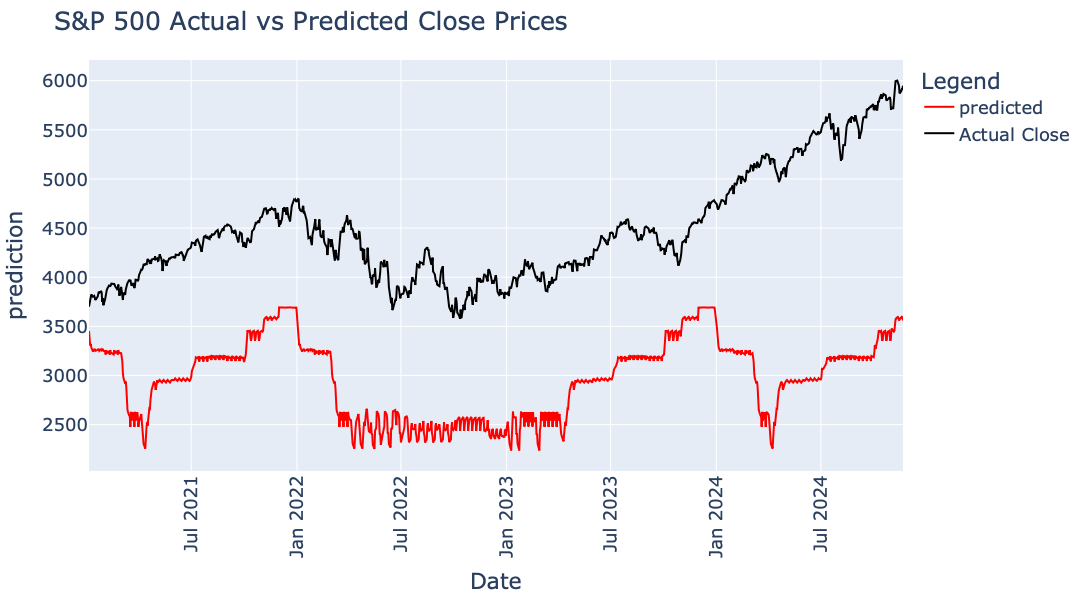

In [154]:
PLTvisualize(predictions1, test)

In [157]:
RMSE = getRMSE(predictions1, test) 
print("RMSE XGBoost:", RMSE)

RMSE XGBoost: 2542069.4339841185


### Let's try artificially uniformily increase the prediction values

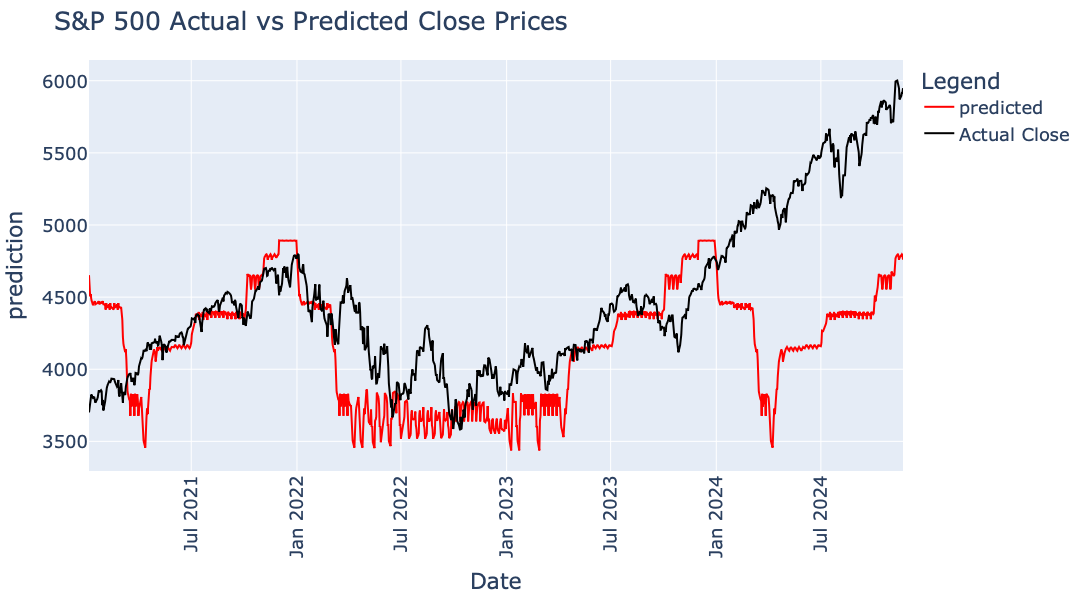

In [160]:
predictions_inflated = predictions1.copy()
predictions_inflated['prediction'] = predictions_inflated['prediction'] + 1200 
PLTvisualize(predictions_inflated, test)

In [162]:
RMSE_inflated = getRMSE(predictions_inflated, test) 
print("RMSE XGBoost:", RMSE_inflated)

RMSE XGBoost: 358492.087133211


## • Verdict: by visual investigation, the model seems to do somewhat of a "decent" job by simple visual inspection. But the RMSE is too high, and it can't discover new highs; showing that it is not able to learn inflation.

# 6. Using Different Models

### 6-1 GAMs for Time Series

### 6-b 

In [41]:
6-1

5